In [276]:
import requests
import pandas as pd
import io
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np

In [871]:
cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'

In [1159]:
r = requests.get(cases_url)
data = r.text
cases_df = pd.read_csv(io.StringIO(data))

In [1160]:
r = requests.get(deaths_url)
data = r.text
deaths_df = pd.read_csv(io.StringIO(data))

In [1161]:
# for cases and deaths we need to normalize these into date, state, count rows
# first drop unneeded columns
# then group by state and aggregate the sum of counties in the state
# then melt the date columns into rows
# generate the new cases value by subtracting the current date from prior
# and reset the index, whew!
cdf = cases_df.\
    drop(columns=['UID', 'code3', 'FIPS', 'Lat', 'Long_']).\
    groupby(['Province_State']).\
    agg(sum).\
    reset_index().\
    melt(id_vars='Province_State', var_name='date', value_name='cases').\
    rename(columns={'Province_State': 'state'})
cdf['date'] = pd.to_datetime(cdf.date)
cdf['new_cases'] = cdf.groupby('state').cases.shift(0) - cdf.groupby('state').cases.shift(1)
cdf['new_cases'] = cdf.new_cases.fillna(0).astype(int)
cdf.set_index(['date', 'state'], inplace=True)
    
ddf = deaths_df.\
    drop(columns=['UID', 'code3', 'FIPS', 'Lat', 'Long_', 'Population']).\
    groupby(['Province_State']).\
    agg(sum).\
    reset_index().\
    melt(id_vars='Province_State', var_name='date', value_name='deaths').\
    rename(columns={'Province_State': 'state'})
ddf['date'] = pd.to_datetime(ddf.date)
ddf['new_deaths'] = ddf.groupby('state').deaths.shift(0) - ddf.groupby('state').deaths.shift(1)
ddf['new_deaths'] = ddf.new_deaths.fillna(0).astype(int)
ddf.set_index(['date', 'state'], inplace=True)

# then to get the 3 and 7 day rolling averages it's easier when the data is in one normal df
# we need to have the same indexes to make it work correctly, which is a lot of hoops
df = cdf.join(ddf).reset_index().set_index(['date', 'state'])
df['new_cases_roll10'] = df.groupby('state').new_cases.rolling(10).mean().fillna(0).astype(int).reset_index(level=0).new_cases
df['new_deaths_roll10'] = df.groupby('state').new_deaths.rolling(10).mean().fillna(0).astype(int).reset_index(level=0).new_deaths
df['new_cases_roll7'] = df.groupby('state').new_cases.rolling(7).mean().fillna(0).astype(int).reset_index(level=0).new_cases
df['new_deaths_roll7'] = df.groupby('state').new_deaths.rolling(7).mean().fillna(0).astype(int).reset_index(level=0).new_deaths
df['new_cases_roll3'] = df.groupby('state').new_cases.rolling(3).mean().fillna(0).astype(int).reset_index(level=0).new_cases
df['new_deaths_roll3'] = df.groupby('state').new_deaths.rolling(3).mean().fillna(0).astype(int).reset_index(level=0).new_deaths

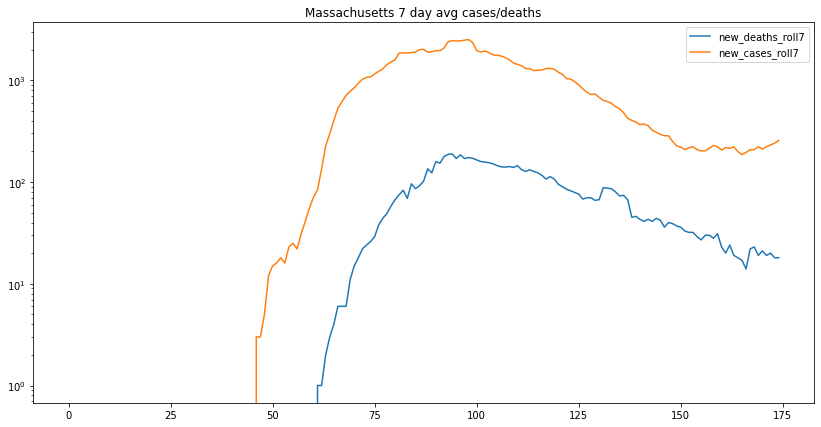

In [1169]:
# and we can plot the two curves - new cases and deaths
state = 'Massachusetts'
plt.rcParams['figure.figsize'] = (14,7)
df.query(f'state == "{state}"').\
    reset_index().\
    loc[:, ['new_deaths_roll7', 'new_cases_roll7']].\
    plot(logy=True, title=f'{state} 7 day avg cases/deaths')

/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


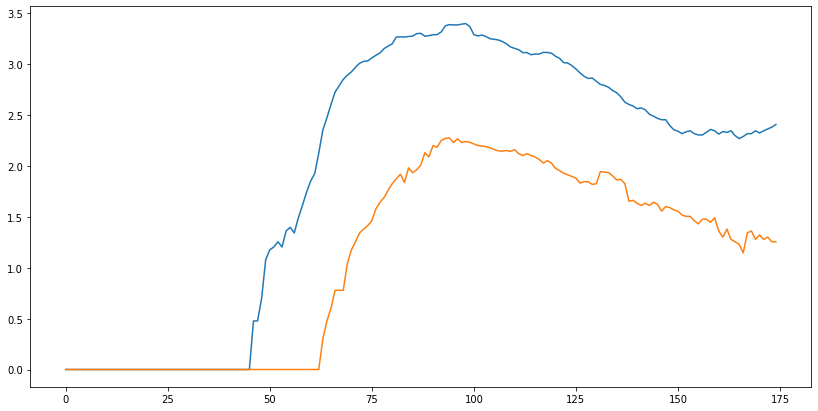

In [1170]:
log_deaths = np.log10(df.query(f'state == "{state}"').reset_index().new_deaths_roll7)
log_deaths[np.isneginf(log_deaths)] = 0
log_deaths = log_deaths.tolist()
log_cases = np.log10(df.query(f'state == "{state}"').reset_index().new_cases_roll7)
log_cases[np.isneginf(log_cases)] = 0
log_cases = log_cases.tolist()

#scaler = preprocessing.minmax_scale
#scaler = preprocessing.MinMaxScaler().fit(log_deaths[:120])
scaler = preprocessing.minmax_scale
#scaler = preprocessing.robust_scale
scaled_deaths = scaler(log_deaths)
scaled_cases = scaler(log_cases)

# if we offset the deaths how close do we get?
plt.plot(log_cases)
plt.plot(log_deaths)
plt.show()

/usr/local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Sqr error of cases vs death offset for Massachusetts (15)')

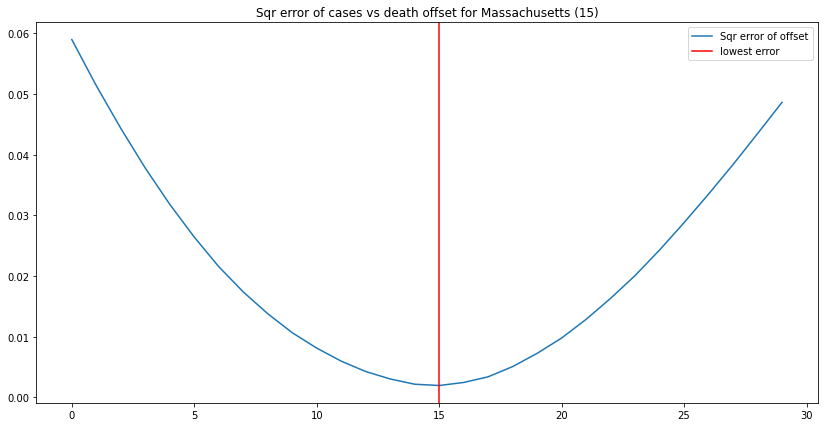

In [1171]:
def offset_sqr_error(offset, cases, deaths, max_offset=100):
    sqr_error = ((cases[:max_offset] - deaths[offset:max_offset+offset]) ** 2).mean()
    return sqr_error


def offset_sqr_error2(offset, cases, deaths, max_offset=100):
    # this gives slightly more weight to newer data than older data
    # since relationships change slightly over time, this tries to find a better
    # recent fit instead of best overall fit
    pwr = 1 + (np.e ** ((offset+1) / len(cases)))
    sqr_error = (
        np.array(cases[:max_offset] - deaths[offset:max_offset+offset], dtype=np.complex) ** pwr).mean()
    return sqr_error

max_consider = 90
errors = [
    offset_sqr_error2(x, scaled_cases, scaled_deaths, max_offset=max_consider) 
    for x in range(30) 
    if x+max_consider < len(scaled_cases)
]
lowest_offset = errors.index(min(errors))
plt.plot(errors)
plt.axvline(lowest_offset, c='r')
plt.legend(['Sqr error of offset', 'lowest error'])
plt.title(f'Sqr error of cases vs death offset for {state} ({lowest_offset})')

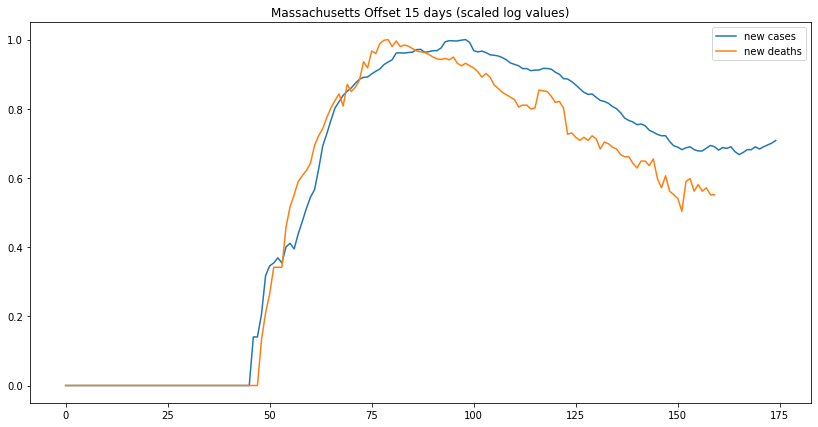

In [1172]:
# what happens if we scale the values based on min/max? they look damn fucking close
# using robust scale instead of say min/max since we know that the two weeks or so
# can leave a pretty large anomaly in scale, also given higher testing
#lowest_offset = lowes

plt.plot(scaled_cases)
plt.plot(scaled_deaths[lowest_offset:])
plt.title(f'{state} Offset {lowest_offset} days (scaled log values)')
plt.legend(['new cases', 'new deaths'])
plt.show()

In [1173]:
# offset for every state
def find_low_offset(state, df, max_offset=120):
    log_deaths = np.log(df.query(f'state == "{state}"').reset_index().new_deaths_roll7)
    log_deaths[np.isneginf(log_deaths)] = 0
    log_deaths = log_deaths.tolist()
    log_cases = np.log(df.query(f'state == "{state}"').reset_index().new_cases_roll7)
    log_cases[np.isneginf(log_cases)] = 0
    log_cases = log_cases.tolist()

    #scaler = preprocessing.minmax_scale
    scaler = preprocessing.minmax_scale
    scaled_deaths = scaler(log_deaths)
    scaled_cases = scaler(log_cases)

    errors = [offset_sqr_error(x, scaled_cases, scaled_deaths, max_offset) for x in range(30)]
    lowest_offset = errors.index(min(errors))
    return lowest_offset

In [1167]:
states = df.reset_index().state.unique().tolist()
errors = [find_low_offset(state, df, max_offset=60) for state in states]
avg = sum(errors) / len(errors)


/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inpu

In [1157]:
print(f"average delay time {avg}")

average delay time 10.017241379310345
